In [1]:
from matplotlib import pyplot as plt
from hddm.simulators import simulator
import hddm
import numpy as np
import pandas as pd
import scipy.sparse as sp
import gc

import sys
sys.path.append("../Codes")
from utils import *
from chain import *
from Hall1997 import *


In [2]:
hddm.model_config.model_config["angle"]


{'doc': 'Model formulation is described in the documentation under LAN Extension.\nMeant for use with the extension.',
 'params': ['v', 'a', 'z', 't', 'theta'],
 'params_trans': [0, 0, 1, 0, 0],
 'params_std_upper': [1.5, 1.0, None, 1.0, 1.0],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1], [3.0, 3.0, 0.9, 2.0, 1.3]],
 'boundary': <function ssms.basic_simulators.boundary_functions.angle(t=1, theta=1)>,
 'params_default': [0.0, 1.0, 0.5, 0.001, 0.1],
 'hddm_include': ['v', 'a', 't', 'z', 'theta'],
 'choices': [-1, 1],
 'slice_widths': {'v': 1.5,
  'v_std': 1,
  'a': 1,
  'a_std': 1,
  'z': 0.1,
  'z_trans': 0.2,
  't': 0.01,
  't_std': 0.15,
  'theta': 0.1,
  'theta_std': 0.2}}

### test 1: Set $\theta=0$

Note that the space considered in angle model and LAN is $[-a,a]$, while that in DDM and wfpt is $[0, a]$.

Also the angle model and LAN implements the non-decision time.

#### plot the first passage time density

In [3]:
# parameters
mu = 1.0
a = 1.5
z = 0.5
t_nd = 0.5
theta = 0
out = simulator(model="angle", theta=[mu, a, z, t_nd, theta], n_samples=10000)


In [4]:
rts, choices, metadata = out
print("rts: " + str(rts.shape))
print("choices: " + str(choices.shape))
print("metadata: ")
for key in metadata:
    print(key, end=": ")
    print(metadata[key])


rts: (10000, 1)
choices: (10000, 1)
metadata: 
v: [1.]
a: [1.5]
z: [0.5]
t: [0.5]
s: 1.0
theta: [0.]
delta_t: 0.0010000000474974513
max_t: 20.0
n_samples: 10000
simulator: ddm_flexbound
boundary_fun_type: angle
possible_choices: [-1, 1]
trajectory: [[ 0.0000000e+00]
 [-3.4898298e-04]
 [-4.8563141e-02]
 ...
 [-9.9900000e+02]
 [-9.9900000e+02]
 [-9.9900000e+02]]
boundary: [1.5 1.5 1.5 ... 1.5 1.5 1.5]
model: angle


In [5]:
# Get data into format accepted by hddm package (below)
data = pd.DataFrame(
    np.stack([np.squeeze(out[0]), np.squeeze(out[1])]).T, columns=["rt", "response"]
)
data["subject"] = 0
data


,rt,response,subject
0,2.498037,1.0,0
1,1.479991,1.0,0
2,2.812015,1.0,0
3,2.049016,1.0,0
4,2.504037,1.0,0
...,...,...,...
9995,2.576032,1.0,0
9996,0.948998,1.0,0
9997,1.475991,1.0,0
9998,2.508037,1.0,0


In [6]:
# Get the model
lan_angle = hddm.network_inspectors.get_torch_mlp(model="angle")


In [7]:
# prob1 stands for wfpt
# prob2 stands for MC_Angle
# prob3 stands for MC_DDM
# prob4 stands for LAN
# prob5 stands for Hall1997

prob1_list = []
prob2_list = []
prob3_list = []
prob5_list = []

mc2 = MC_Angle(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.001, Nx=80)
mc3 = MC_DDM(mu=mu, sigma=1, a=2 * a, z=z, dt=0.001, Nx=80, verbose=False)

T_list = np.linspace(0.5+0.001, 8, 100)
rT_list = np.hstack((T_list, T_list)).reshape(-1, 1)
choice_list = np.hstack((np.ones(T_list.shape), -np.ones(T_list.shape))).reshape(-1, 1)
para_matrix = np.tile(np.array([mu, a, z, t_nd, theta]), (200, 1))
network_input = np.hstack((para_matrix, rT_list, choice_list)).astype(np.float32)
prob4_list = np.exp(lan_angle(network_input))

print("upper:")
for T in T_list:
    print("{:.4f}".format(T), end=" ")
    prob1 = wfpt(T - t_nd, -mu, 2 * a, 1-z, 1e-10)
    prob2 = mc2.ExitProb_dp(T=T, s=a) / mc2.dt
    prob3 = mc3.ExitProb_dp1(T=T - t_nd, s=2*a) / mc3.dt
    prob5 = density(mu, a, theta, T-t_nd, trunc_num=40, bdy="upper")
    prob1_list.append(prob1)
    prob2_list.append(prob2)
    prob3_list.append(prob3)
    prob5_list.append(prob5)
    gc.collect()
print()
print("lower:")
for T in T_list:
    print("{:.4f}".format(-T), end=" ")
    prob1 = wfpt(T - t_nd, mu, 2 * a, z, 1e-10)
    prob2 = mc2.ExitProb_dp(T=T, s=-a) / mc2.dt
    prob3 = mc3.ExitProb_dp1(T=T - t_nd, s=0) / mc3.dt
    prob5 = density(mu, a, theta, T-t_nd, trunc_num=40, bdy="lower")
    prob1_list.append(prob1)
    prob2_list.append(prob2)
    prob3_list.append(prob3)
    prob5_list.append(prob5)
    gc.collect()
    


upper:
0.5010 0.5767 0.6525 0.7282 0.8040 0.8797 0.9555 1.0312 1.1070 1.1827 1.2585 1.3342 1.4100 1.4857 1.5615 1.6372 1.7130 1.7887 1.8645 1.9402 2.0159 2.0917 2.1674 2.2432 2.3189 2.3947 2.4704 2.5462 2.6219 2.6977 2.7734 2.8492 2.9249 3.0007 3.0764 3.1522 3.2279 3.3037 3.3794 3.4552 3.5309 3.6066 3.6824 3.7581 3.8339 3.9096 3.9854 4.0611 4.1369 4.2126 4.2884 4.3641 4.4399 4.5156 4.5914 4.6671 4.7429 4.8186 4.8944 4.9701 5.0458 5.1216 5.1973 5.2731 5.3488 5.4246 5.5003 5.5761 5.6518 5.7276 5.8033 5.8791 5.9548 6.0306 6.1063 6.1821 6.2578 6.3336 6.4093 6.4851 6.5608 6.6365 6.7123 6.7880 6.8638 6.9395 7.0153 7.0910 7.1668 7.2425 7.3183 7.3940 7.4698 7.5455 7.6213 7.6970 7.7728 7.8485 7.9243 8.0000 
lower:
-0.5010 -0.5767 -0.6525 -0.7282 -0.8040 -0.8797 -0.9555 -1.0312 -1.1070 -1.1827 -1.2585 -1.3342 -1.4100 -1.4857 -1.5615 -1.6372 -1.7130 -1.7887 -1.8645 -1.9402 -2.0159 -2.0917 -2.1674 -2.2432 -2.3189 -2.3947 -2.4704 -2.5462 -2.6219 -2.6977 -2.7734 -2.8492 -2.9249 -3.0007 -3.0764 -3.15

In [8]:
sort_idx = np.argsort(network_input[:, -2] * network_input[:, -1])
signedT_list = (network_input[:, -2] * network_input[:, -1])[sort_idx]

prob1_array = np.array(prob1_list)[sort_idx]
prob2_array = np.array(prob2_list)[sort_idx]
prob3_array = np.array(prob3_list)[sort_idx]
prob4_array = np.array(prob4_list)[sort_idx]
prob5_array = np.array(prob5_list)[sort_idx]

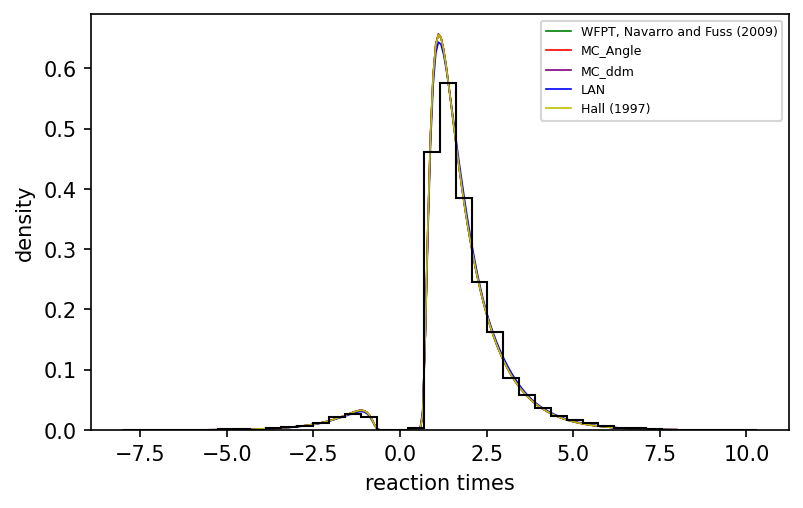

In [9]:
fig, ax = plt.subplots(figsize=(6, 3.6), dpi=150)
ax.plot(signedT_list, prob1_array, label='WFPT, Navarro and Fuss (2009)', lw=0.8, c='g')
ax.plot(signedT_list, prob2_array, label='MC_Angle', lw=0.8, c='r')
ax.plot(signedT_list, prob3_array, label='MC_ddm', lw=0.8, c='purple')
ax.plot(signedT_list, prob4_array, label='LAN', lw=0.8, c='b')
ax.plot(signedT_list, prob5_array, label='Hall (1997)', lw=0.8, c='y')

ax.hist(
    np.squeeze(out[0]) * np.squeeze(out[1]), histtype="step", bins=40, color="black", density=True
)
ax.set_xlabel("reaction times")
ax.set_ylabel("density")
ax.legend(fontsize=6)
plt.show()

### test 2: For the Angle model with $\theta\neq0$

In [10]:
mu = 1
a = 1.5
z = 0.5
t_nd = 0.5
theta = 0.3
out = simulator(model="angle", theta=[mu, a, z, t_nd, theta], n_samples=10000)

In [35]:
prob2_list = []
prob5_list = []

mc2 = MC_Angle(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.001, Nx=80) # dt=0.0002, Nx=200 for a dense approx

T_list = np.linspace(0.5+0.001, 8, 100)
rT_list = np.hstack((T_list, T_list)).reshape(-1, 1)
choice_list = np.hstack((np.ones(T_list.shape), -np.ones(T_list.shape))).reshape(-1, 1)
para_matrix = np.tile(np.array([mu, a, z, t_nd, theta]), (200, 1))
network_input = np.hstack((para_matrix, rT_list, choice_list)).astype(np.float32)
prob4_list = np.exp(lan_angle(network_input))


print("upper:")

flag = True
for T in T_list:
    print("{:.4f}".format(T), end=" ")
    if flag:
        prob5 = density(mu, a, theta, T-t_nd, trunc_num=10, bdy="upper")
        if prob5 < 0:
            flag = False
            print()
            print("Hall1997 method breaks at T-t_nd=%.4f" %(T-t_nd))
            prob5_list.append(-1)
        else:
            prob5_list.append(prob5)
    else:
        prob5_list.append(-1)
    prob2 = mc2.ExitProb_dp(T=T, s=mc2.upper_bdy(T-mc2.t_nd)) / mc2.dt
    prob2_list.append(prob2)
    gc.collect()

print()
print("lower:")

flag = True
for T in T_list:
    print("{:.4f}".format(-T), end=" ")
    if flag:
        prob5 = density(mu, a, theta, T-t_nd, trunc_num=10, bdy="lower")
        if prob5 < 0:
            flag = False
            print()
            print("Hall1997 method breaks at T-t_nd=%.4f" %(T-t_nd))
            prob5_list.append(-1)
        else:
            prob5_list.append(prob5)
    else:
        prob5_list.append(-1)
    prob2 = mc2.ExitProb_dp(T=T, s=mc2.lower_bdy(T-mc2.t_nd)) / mc2.dt
    prob2_list.append(prob2)
    gc.collect()
    


upper:
0.5010 0.5767 0.6525 0.7282 0.8040 0.8797 0.9555 1.0312 1.1070 1.1827 1.2585 1.3342 1.4100 1.4857 1.5615 1.6372 1.7130 1.7887 1.8645 1.9402 2.0159 2.0917 2.1674 2.2432 2.3189 2.3947 2.4704 2.5462 2.6219 2.6977 2.7734 2.8492 2.9249 3.0007 3.0764 3.1522 3.2279 3.3037 3.3794 3.4552 3.5309 3.6066 3.6824 3.7581 3.8339 3.9096 3.9854 4.0611 4.1369 4.2126 4.2884 4.3641 4.4399 4.5156 4.5914 4.6671 4.7429 4.8186 4.8944 4.9701 5.0458 5.1216 
Hall1997 method breaks at T-t_nd=4.6216
5.1973 5.2731 5.3488 5.4246 5.5003 5.5761 5.6518 5.7276 5.8033 5.8791 5.9548 6.0306 6.1063 6.1821 6.2578 6.3336 6.4093 6.4851 6.5608 6.6365 6.7123 6.7880 6.8638 6.9395 7.0153 7.0910 7.1668 7.2425 7.3183 7.3940 7.4698 7.5455 7.6213 7.6970 7.7728 7.8485 7.9243 8.0000 
lower:
-0.5010 -0.5767 -0.6525 -0.7282 -0.8040 -0.8797 -0.9555 -1.0312 -1.1070 -1.1827 -1.2585 -1.3342 -1.4100 -1.4857 -1.5615 -1.6372 -1.7130 -1.7887 -1.8645 -1.9402 -2.0159 -2.0917 -2.1674 -2.2432 -2.3189 -2.3947 -2.4704 -2.5462 -2.6219 -2.6977 -2.7

In [36]:
sort_idx = np.argsort(network_input[:, -2] * network_input[:, -1])
signedT_list = (network_input[:, -2] * network_input[:, -1])[sort_idx]

prob2_array = np.array(prob2_list)[sort_idx]
prob4_array = np.array(prob4_list)[sort_idx]
prob5_array = np.array(prob5_list)[sort_idx]

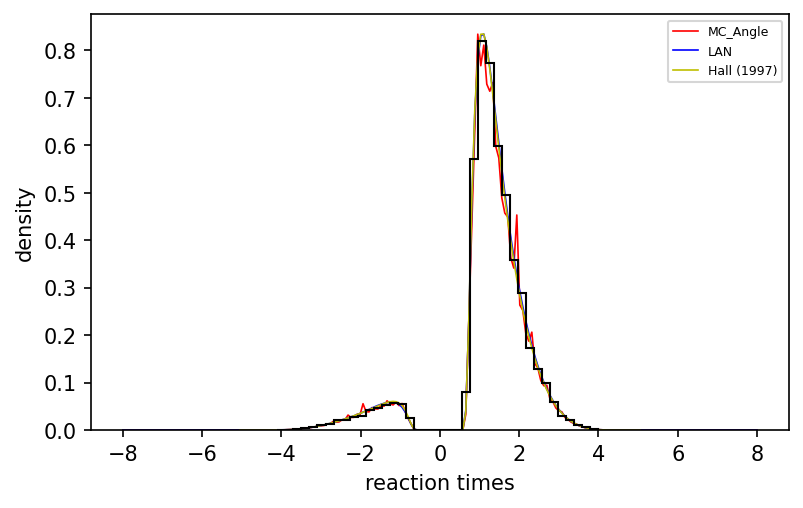

In [37]:
fig, ax = plt.subplots(figsize=(6, 3.6), dpi=150)
ax.plot(signedT_list, prob2_array, label='MC_Angle', lw=0.8, c='r')
ax.plot(signedT_list, prob4_array, label='LAN', lw=0.8, c='b')
ax.plot(signedT_list[prob5_array>0], prob5_array[prob5_array>0], label='Hall (1997)', lw=0.8, c='y')

ax.hist(
    np.squeeze(out[0]) * np.squeeze(out[1]), histtype="step", bins=40, color="black", density=True
)
ax.set_xlabel("reaction times")
ax.set_ylabel("density")
ax.legend(fontsize=6)
plt.show()

In [20]:
density(mu, a, theta, 4, trunc_num=10, bdy="upper", debug=True)

-0.012335044410629268
0.011157841166181504
0.0011769269504404716
1.3139013640474605e-05
2.0752154451023057e-08
5.020805191656219e-12
1.921213865521322e-16
1.1807683872645574e-21
1.1754312279037332e-27
1.9049239373024464e-34


1.2883476808630463e-05